In [1]:
import sys
sys.path.append("../") 

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='../data',cache=True,as_frame=False)
X=X/255.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [4]:
import numpy as np
from hamiltonian import utils

num_examples,num_inputs=X_train.shape
num_outputs=len(np.unique(y_train))

#y_train=utils.one_hot(y_train,num_outputs)
#y_test=utils.one_hot(y_test,num_outputs)

In [5]:
y_train=np.int32(y_train)
y_test=np.int32(y_test)

In [7]:

import mxnet as mx
from mxnet import nd, autograd, gluon


model_ctx=mx.cpu()
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':nd.array(20.0, ctx=model_ctx)}

In [8]:
mx.cpu()

cpu(0)

In [10]:
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgd(model,par,step_size=0.05,ctx=model_ctx)

In [25]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgd)

<module 'hamiltonian.inference.sgd' from '../hamiltonian/inference/sgd.py'>

In [16]:
par,loss=inference.fit(epochs=100,batch_size=64,gamma=0.9,X_train=X_train,y_train=y_train,verbose=False)

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


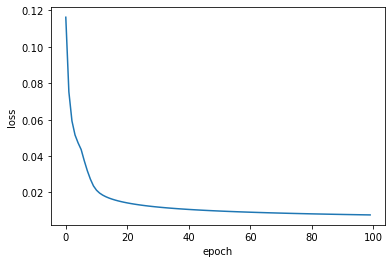

In [17]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [18]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [55]:
samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())

In [56]:
samples=np.asarray(samples)

In [57]:
samples.shape

(100, 14000)

In [60]:
y_hat=np.quantile(samples,.5,axis=0)

In [64]:
from sklearn.metrics import classification_report

print(classification_report(y_test,np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1418
           1       0.94      0.95      0.94      1518
           2       0.86      0.87      0.87      1339
           3       0.85      0.84      0.85      1452
           4       0.88      0.89      0.88      1342
           5       0.80      0.82      0.81      1267
           6       0.91      0.92      0.92      1356
           7       0.89      0.90      0.90      1524
           8       0.83      0.79      0.81      1380
           9       0.85      0.83      0.84      1404

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



In [50]:
X_batch=nd.array(X_train[:32])
y_batch=nd.array(y_train[:32])

In [36]:
like=model.negative_log_likelihood(par,X_train=X_batch,y_train=y_batch)
prior=model.negative_log_prior(par)

In [37]:
like


[328.5955]
<NDArray 1 @cpu(0)>

In [38]:
prior


[-2.6213992]
<NDArray 1 @cpu(0)>

In [ ]:
like+prior